In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from SceneR2.core import *
from SceneR2.learners import ModelLearner, ParallelLearner
from SceneR2.dataset import CANData, MovingObjectData, SingleCAN, MovingObjectData2
from SceneR2.dataset import *
from SceneR2.loss import weightedMSE, FocalMultiClass
from SceneR2.utils.dataset import PadCollate
import pickle

In [3]:
! which python

/home/sufiyan/anaconda3/envs/fastai/bin/python


As loading and cleaning the dataset takes some time, we load the dataset and save it in a pickle file to be loaded below. This makes the process of loading the dataset quicker the next time we run the model.

In [ ]:
data=MovingObjectData2.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovObj2_cleaned_157_26Feb", 'wb') as f:
    pickle.dump(data, f)

Loading the dataset. To see how the dataset works, see [SceneR2/dataset.py](https://github.com/dumbPy/MTP/blob/master/SceneR2/dataset.py)

In [4]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovObj2_cleaned_157_26Mar", 'rb') as f:
    dataset=pickle.load(f)

In [ ]:
os.getcwd()

[]
ABAReactionIndex:  466
ABAReactionStopIndex: 606
Edge_0:  []
Edge_1:  [576, 577]
Reason for Braking:  Driving/Moving Object
Label:  0
edgePostABA:  576


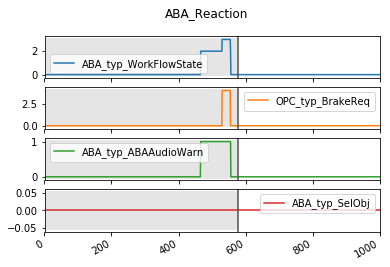

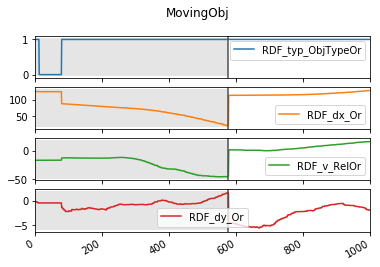

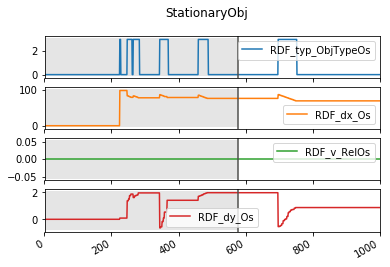

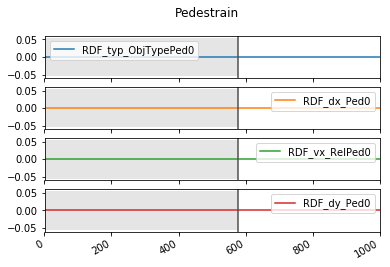

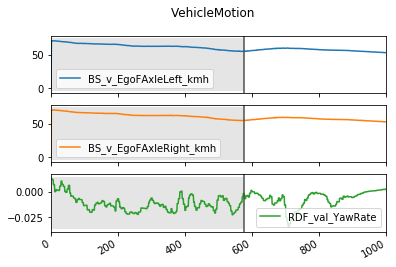

In [6]:
dataset.plot(1, supressPostABA=False, all_columns=True, verbose=True)

Total number of files in the dataset

In [7]:
len(dataset)

158

Number of files for **Left**, **Right** and **Other** classes respectively. These include flipped files for Left and Right

In [8]:
print(len([1 for x,y in dataset if y==0]))
print(len([1 for x,y in dataset if y==1]))
print(len([1 for x,y in dataset if y==2]))

61
62
35


Seperating train and test files.

In [6]:
np.random.seed(10) #seting seed for always selecting same train and test set
totalFiles=len(dataset)
testFiles=np.random.choice(totalFiles, int(0.2*totalFiles)) #20% files as test files

Defining the Dataloaders for training and validation data

In [10]:
trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if not i in testFiles], collate_fn=PadCollate(dim=0), batch_size=200, num_workers=2)
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if i in testFiles], collate_fn=PadCollate(dim=0), batch_size=200, num_workers=2)

A simple model defined below is trained. It consists of a 2 Layer LSTM followed by a fully connected Layer

In [12]:
class CSVmodel(nn.Module):
    def __init__(self,categories=3, input_size=4, hidden_size=20, dropout=0.1):
        super().__init__()
        self.l1=nn.LSTM(input_size=input_size,hidden_size=hidden_size, dropout=dropout, num_layers=2, batch_first=True)
        self.l2=nn.Linear(in_features=hidden_size,out_features=categories)
        self.softmax=nn.Softmax()
    def forward(self,x, x_sizes):
        x,(hn,cn)=self.l1(x)
        x=torch.stack([x[i, x_sizes[i]-1,:] for i in range(len(x))])
        x= self.l2(hn[1])
        return x

ParallelLearner class takes ModelLearners that take models and other parameters like learning rate, optimization function and loss function.

In [13]:
learner=ParallelLearner(
                [ModelLearner(CSVmodel(input_size=19), lr=0.001, loss_fn=partial(FocalMultiClass, gamma=5), 
                              optim=torch.optim.Adam, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(input_size=19), lr=0.001, loss_fn=partial(weightedMSE, [1,1,20]), 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(input_size=19), lr=0.001, loss_fn=partial(nn.CrossEntropyLoss, torch.tensor([1,1,20]).float()), optim=torch.optim.SGD, 
                             modelName='movingObjectDataModel' ),
                ],
        epochs=10, trainLoader=trainLoader, validLoader=testLoader)

The ParallelLearner trains all the models parallelly by using the same data

In [14]:
learner.train(100)

Plotting the loss for all the 4 models above. 

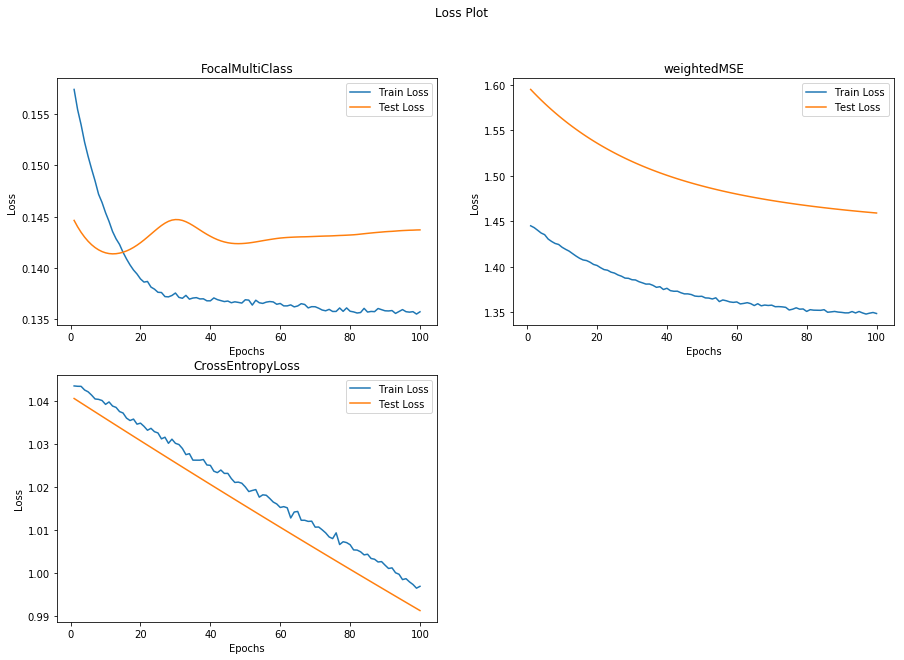

In [15]:
learner.plotLoss(figsize=(15,10))

Plotting confusion matrix for training dataset for all the four loss functions namely weighted_MSE (1,1,0.1), weighted_MSE(0.5, 0.5, 0.1), MSE and CrossEntropyLoss.

In [16]:
print("wMSE1"); print(learner.learners[0].train_confusion_matrix_list[-1])
print("wMSE2"); print(learner.learners[1].train_confusion_matrix_list[-1])
print("MSE"); print(learner.learners[2].train_confusion_matrix_list[-1])
# print("CE"); print(learner.learners[3].train_confusion_matrix_list[-1])

wMSE1
[[53  0  0]
 [48  1  0]
 [27  0  1]]
wMSE2
[[ 0 53  0]
 [ 0 49  0]
 [ 0 28  0]]
MSE
[[ 0  0 53]
 [ 0  0 49]
 [ 0  0 28]]


Confision Matrix for all the loss functions for test data

In [18]:
print("wMSE1"); print(learner.learners[0].valid_confusion_matrix_list[-1])
print("wMSE2"); print(learner.learners[1].valid_confusion_matrix_list[-1])
print("MSE"); print(learner.learners[2].valid_confusion_matrix_list[-1])
# print("CE"); print(learner.learners[3].valid_confusion_matrix_list[-1])

wMSE1
[[ 8  0  0]
 [13  0  0]
 [ 7  0  0]]
wMSE2
[[ 0  8  0]
 [ 0 13  0]
 [ 0  7  0]]
MSE
[[ 0  0  8]
 [ 0  0 13]
 [ 0  0  7]]


In [19]:
data=MovingObjectData2.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovObj2_17Apr", 'wb') as f:
    pickle.dump(data, f)

100%|██████████| 161/161 [01:55<00:00,  1.40it/s]


In [4]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovObj2_17Apr", 'rb') as f:
    dataset=pickle.load(f)

In [5]:
np.random.seed(10) #seting seed for always selecting same train and test set
totalFiles=len(dataset)
testFiles=np.random.choice(totalFiles, int(0.2*totalFiles)) #20% files as test files

In [6]:
# trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if not i in testFiles], collate_fn=PadCollate(dim=0), batch_size=50, num_workers=2)
# testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if i in testFiles], collate_fn=PadCollate(dim=0), batch_size=50, num_workers=2)

trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if not i in testFiles], num_workers=2)
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if i in testFiles], num_workers=2)

In [7]:
class CSVmodel_2(nn.Module):
    def __init__(self,categories=3, input_size=4, hidden_size=20, dropout=0.1):
        super().__init__()
        self.l1=nn.LSTM(input_size=input_size,hidden_size=hidden_size, dropout=dropout, num_layers=2, batch_first=True)
        self.l2=nn.Linear(in_features=hidden_size,out_features=categories)
        self.softmax=nn.Softmax()
    def forward(self,x):
        x,_=self.l1(x)
        x=x[:,-1,:]
        x= self.l2(x)
        return x

In [8]:
learner=ParallelLearner(
                [
                ModelLearner(CSVmodel_2(input_size=4), lr=0.001, loss_fn=partial(weightedMSE, [1,1,20]), 
                             optim=torch.optim.Adam, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel_2(input_size=4), lr=0.001, loss_fn=partial(nn.CrossEntropyLoss, torch.tensor([1,1,2]).float()), optim=torch.optim.Adam, 
                             modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel_2(input_size=4), lr=0.001, loss_fn=partial(FocalMultiClass, gamma=5), 
                              optim=torch.optim.Adam, modelName='movingObjectDataModel')
                ],
        epochs=10, trainLoader=trainLoader, validLoader=testLoader)

In [9]:
learner.train(10)

In [19]:
for i in range(len(learner.learners)):
    print(learner.learners[i].loss_name)
    print(learner.learners[i].train_confusion_matrix_list[-1])

weightedMSE
[[50  1  2]
 [ 0 48  1]
 [ 3  4 21]]
CrossEntropyLoss
[[52  0  1]
 [ 0 47  2]
 [ 4  3 21]]
FocalMultiClass
[[52  0  1]
 [ 0 49  0]
 [ 3  5 20]]


In [11]:
for i in range(len(learner.learners)):
    print(learner.learners[i].loss_name)
    print(learner.learners[i].train_confusion_matrix_list[-1])

wMSE1
[[ 7  0  1]
 [ 0 13  0]
 [ 1  0  6]]
CE
[[ 7  0  1]
 [ 0 13  0]
 [ 1  2  4]]
Focal
[[ 7  0  1]
 [ 0 12  1]
 [ 1  0  6]]


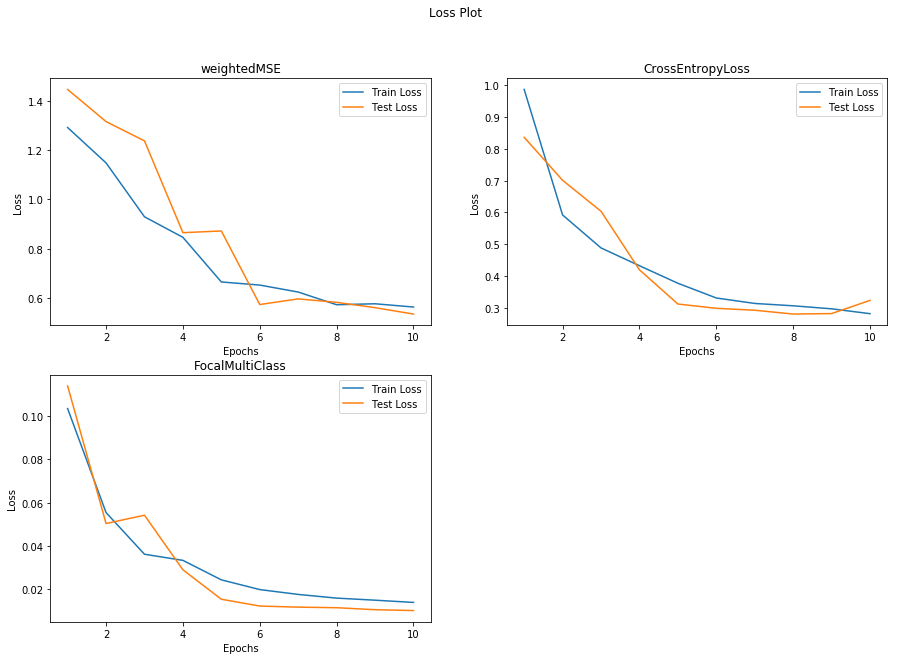

In [13]:
learner.plotLoss(figsize=(15,10))

In [27]:
learner.train(10)

In [28]:
for i in range(len(learner.learners)):
    print(learner.learners[i].loss_name)
    print(learner.learners[i].train_confusion_matrix_list[-1])

weightedMSE
[[51  0  2]
 [ 0 49  0]
 [ 4  4 20]]
CrossEntropyLoss
[[51  0  2]
 [ 0 49  0]
 [ 3  3 22]]
FocalMultiClass
[[52  0  1]
 [ 0 49  0]
 [ 4  4 20]]


In [29]:
for i in range(len(learner.learners)):
    print(learner.learners[i].loss_name)
    print(learner.learners[i].valid_confusion_matrix_list[-1])

weightedMSE
[[ 6  0  2]
 [ 0 11  2]
 [ 1  0  6]]
CrossEntropyLoss
[[ 7  0  1]
 [ 0 13  0]
 [ 1  0  6]]
FocalMultiClass
[[ 8  0  0]
 [ 0 12  1]
 [ 1  0  6]]


In [ ]:
learner.plotLoss(figsize=(15,10))

In [ ]:
lear